# pySCENIC protocol (PN1 data)

In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import seaborn as sns
import matplotlib.pyplot as plt

import json
import zlib
import base64
import umap


/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# path to anndata object, which will be updated to store Scanpy results as they are generated below
f_anndata_path = "PN1_anndata.h5ad"

# path to pyscenic output
f_pyscenic_output = "PN1_pyscenic_output.loom"

# loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'PN1_scenic_integrated-output.loom'

In [3]:

converted_preprocessed_Seurat_object="./h5ad/Mo_PN1_MesCells_mes_doub_res0.5.h5ad"
adata = sc.read(converted_preprocessed_Seurat_object, cache=True)


In [4]:
adata.__dict__['_raw'].__dict__['_var'] 

,_index
0,Xkr4
1,Gm19938
2,Rp1
3,Sox17
4,Gm37587
...,...
20854,4930513O06Rik
20855,Trpc5os
20856,Gpr143
20857,Gm15241


In [5]:

## fix a bug based on this page https://github.com/theislab/scvelo/issues/255\n",
adata.__dict__['_raw'].__dict__['_var'] =  adata.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})

adata.__dict__['_raw'].__dict__['_var'] 

,features
0,Xkr4
1,Gm19938
2,Rp1
3,Sox17
4,Gm37587
...,...
20854,4930513O06Rik
20855,Trpc5os
20856,Gpr143
20857,Gm15241


In [6]:
del adata.var['_index']
adata.var

,features
0,Xkr4
1,Gm19938
2,Rp1
3,Sox17
4,Gm37587
...,...
20854,4930513O06Rik
20855,Trpc5os
20856,Gpr143
20857,Gm15241


## Diagnostic plots, post filtering
#### Three-panel summary plots

/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

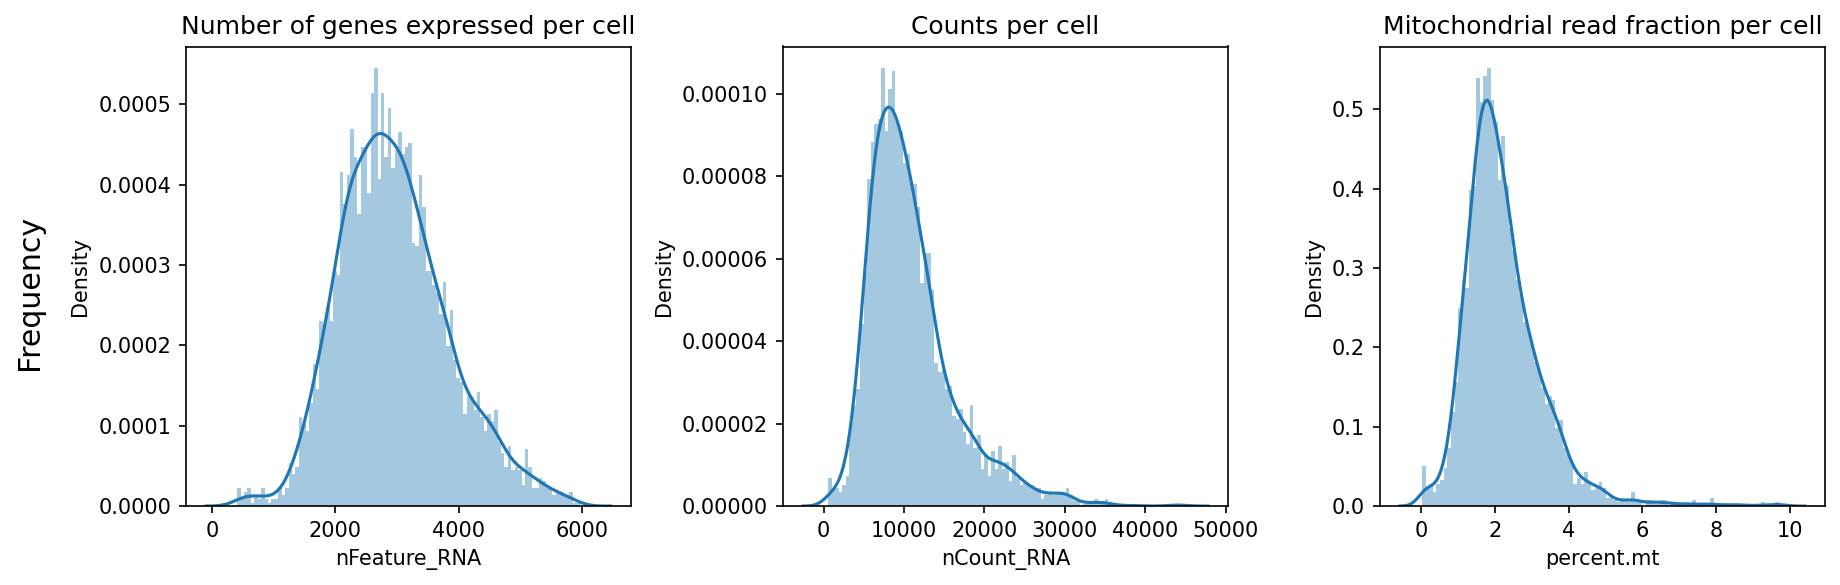

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

adata.obs['nFeature_RNA']

sns.distplot( adata.obs['nFeature_RNA'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['nCount_RNA'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent.mt'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

fig.savefig('filtering_panel_postfilter.pdf', dpi=600, bbox_inches='tight')

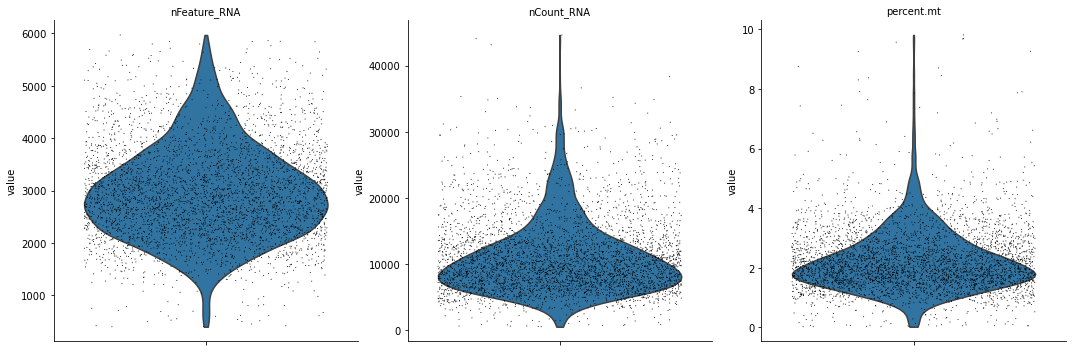

In [8]:
sc.pl.violin(adata, ['nFeature_RNA', 'nCount_RNA', 'percent.mt'],
    jitter=0.4, multi_panel=True )


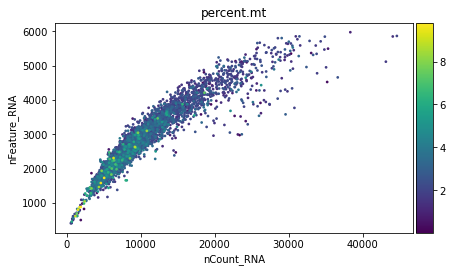

In [9]:
sc.pl.scatter(adata, x='nCount_RNA', y='nFeature_RNA', color='percent.mt')

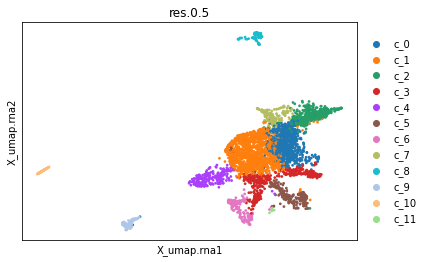

In [10]:
sc.pl.embedding(adata, "X_umap.rna", color="res.0.5" )


##  Further pre-processing of expression data


In [11]:
# save a copy of the raw data
adata.raw = adata

# Total-count normalize (library-size correct) to 10,000 reads/cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# log transform the data.
sc.pp.log1p(adata)

# identify highly variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


In [12]:
adata.var = adata.var.set_index('features')
# set the index to 'None' via its name property
adata.var.index.names = [None]

In [13]:
adata.var
#del adata.raw

,highly_variable,means,dispersions,dispersions_norm
Xkr4,False,8.387476e-03,0.378240,0.297292
Gm19938,False,1.286416e-02,0.277537,0.050960
Rp1,False,3.742668e-03,0.822641,1.384352
Sox17,False,4.594872e-04,-0.435421,-1.693025
Gm37587,False,3.748944e-04,0.419767,0.398872
...,...,...,...,...
4930513O06Rik,False,9.535523e-04,0.286328,0.072464
Trpc5os,False,1.292342e-04,-0.645374,-2.206596
Gpr143,False,1.000000e-12,NaN,0.000000
Gm15241,False,6.111519e-04,0.028850,-0.557360


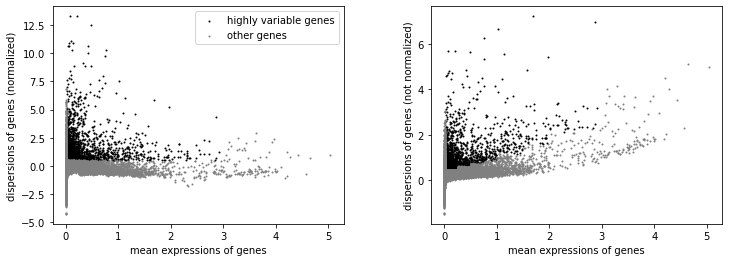

/home/irepan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  import sys


In [14]:
sc.pl.highly_variable_genes(adata)

# keep only highly variable genes:
adata = adata[:, adata.var['highly_variable']]

# regress out total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(adata, ['nCount_RNA', 'percent.mt'] ) #, n_jobs=args.threads)

# scale each gene to unit variance, clip values exceeding SD 10.
sc.pp.scale(adata, max_value=10)

adata.write(f_anndata_path)

## 1 PCA

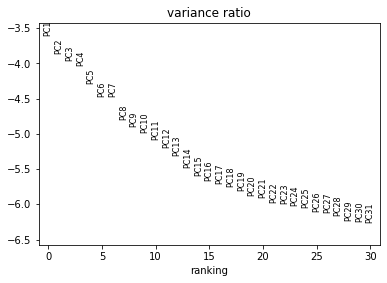

In [15]:
# adata = sc.read_h5ad( f_anndata_path )
# principal component analysis
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
#adata.write( f_anndata_path )

## 2 Visualization

In [16]:
# neighborhood graph of cells (determine optimal number of PCs here)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
# compute UMAP
sc.tl.umap(adata)
# tSNE
tsne = TSNE( n_jobs=20 )
adata.obsm['X_tsne'] = tsne.fit_transform( adata.X )
#adata.write( f_anndata_path )


## 3 Clustering

In [17]:
# cluster the neighbourhood graph
sc.tl.louvain(adata,resolution=0.4)



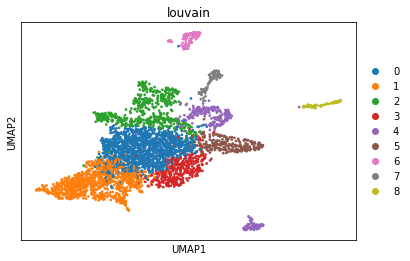

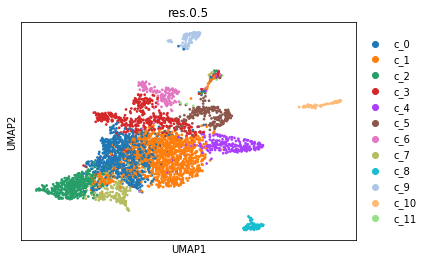

In [18]:
#adata = sc.read_h5ad( f_anndata_path )
sc.pl.umap(adata, color=['louvain'] )
sc.pl.umap(adata, color=['res.0.5'],use_raw=False)

/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:421: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


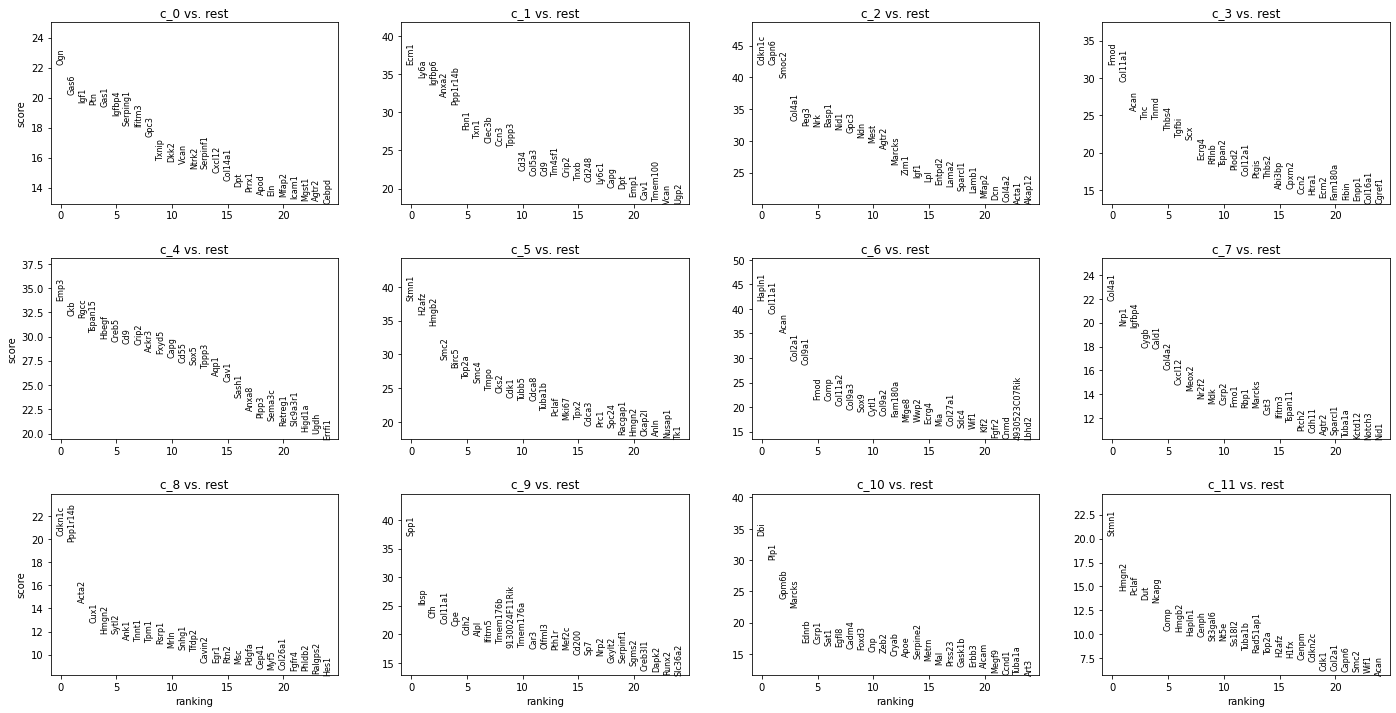

In [19]:
# find marker genes
sc.tl.rank_genes_groups(adata, 'res.0.5', method='t-test', use_raw=False)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)


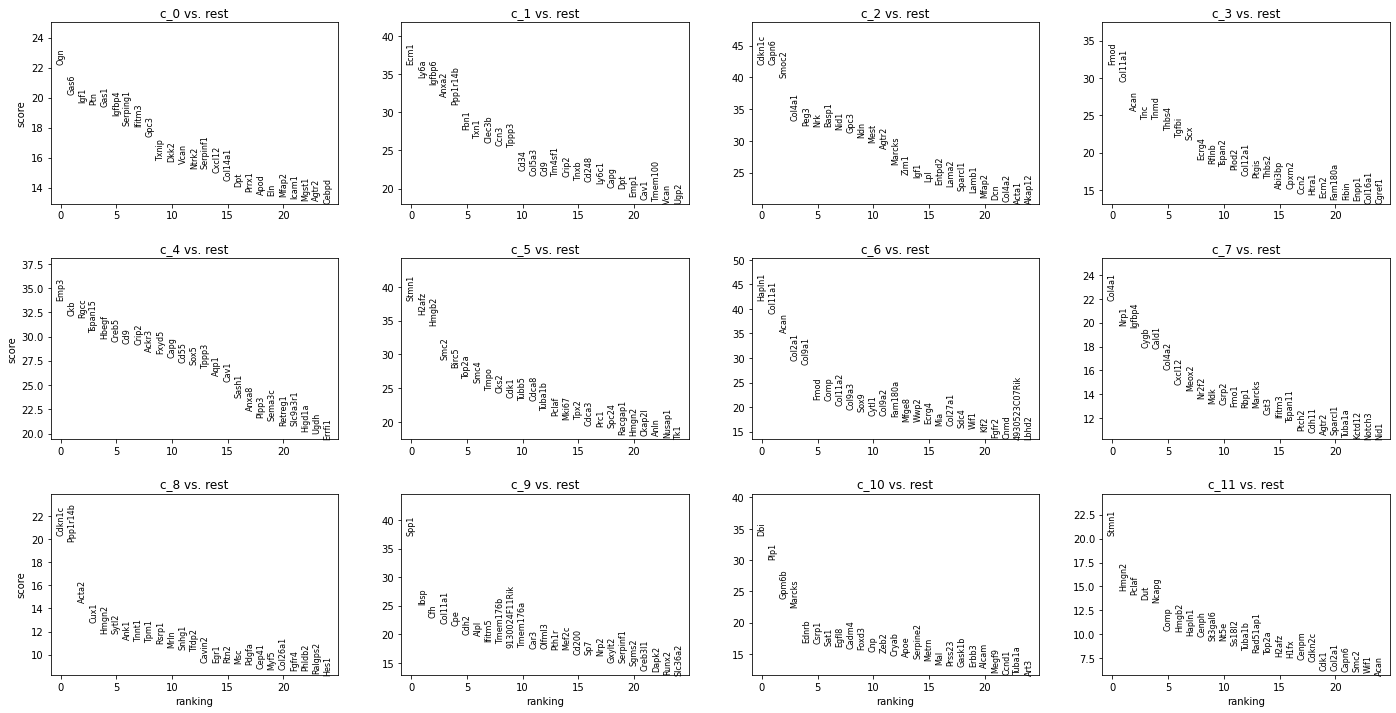

In [20]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
# sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(4)
adata.write( f_anndata_path )

In [21]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11
0,Ogn,Ecm1,Cdkn1c,Fmod,Emp3,Stmn1,Hapln1,Col4a1,Cdkn1c,Spp1,Dbi,Stmn1
1,Gas6,Ly6a,Capn6,Col11a1,Ckb,H2afz,Col11a1,Nrp1,Ppp1r14b,Ibsp,Plp1,Hmgn2
2,Igf1,Igfbp6,Smoc2,Acan,Rgcc,Hmgb2,Acan,Igfbp4,Acta2,Cfh,Gpm6b,Pclaf
3,Ptn,Anxa2,Col4a1,Tnc,Tspan15,Smc2,Col2a1,Cygb,Cux1,Col11a1,Marcks,Dut
4,Gas1,Ppp1r14b,Peg3,Tnmd,Hbegf,Birc5,Col9a1,Cald1,Hmgn2,Cpe,Ednrb,Ncapg
5,Igfbp4,Fbn1,Nrk,Thbs4,Creb5,Top2a,Fmod,Col4a2,Sytl2,Cdh2,Csrp1,Comp
6,Serping1,Txn1,Basp1,Tgfbi,Cd9,Smc4,Comp,Cxcl12,Ank1,Alpl,Sat1,Hmgb2
7,Ifitm3,Clec3b,Nid1,Scx,Crip2,Tmpo,Col11a2,Meox2,Tnnt1,Ifitm5,Egfl8,Hapln1
8,Gpc3,Ccn3,Gpc3,Ecrg4,Ackr3,Cks2,Col9a3,Nr2f2,Tpm1,Tmem176b,Cadm4,Cenph
9,Txnip,Tppp3,Ndn,Rflnb,Fxyd5,Cdk1,Sox9,Mdk,Rsrp1,9130024F11Rik,Foxd3,St3gal6


## SCENIC steps
### STEP 1: Gene regulatory network inference, and generation of co-expression modules
#### Phase Ia: GRN inference using the GRNBoost2 algorithm

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system. We use the counts matrix (without log transformation or further processing) from the loom file we wrote earlier. Output: List of adjacencies between a TF and its targets stored in 

In [22]:
# transcription factors list
adata = sc.read_h5ad( f_anndata_path )
f_tfs = "./data/allTFs_mm.txt"   # mouse
#tf_names = load_tf_names( f_tfs )


### write to an unfiltered loom file

Here, we use the loompy functions directly


In [23]:
# path to unfiltered loom file (this will be created in the optional steps below)
f_loom_path_unfilt = "PN1_unfiltered.loom" # test dataset, n=500 cells

row_attrs = { 
    "Gene": np.array(adata.var.index) ,
}
col_attrs = { 
    "CellID":  np.array(adata.obs.index) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}

lp.create( f_loom_path_unfilt, adata.X.transpose(), row_attrs, col_attrs )

In [24]:
!pyscenic grn {f_loom_path_unfilt} {f_tfs} -o PN1_adj.csv --num_workers 7


2022-06-30 11:22:28,698 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2022-06-30 11:22:28,871 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44375 instead
  f"Port {expected} is already in use.\n"
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child p

In [25]:
adjacencies = pd.read_csv("PN1_adj.csv", index_col=False, sep=',')

In [26]:
adjacencies.head()

,TF,target,importance
0,Peg3,Zim1,205.395948
1,H2afz,Cenpa,202.611765
2,H2afz,Ccnb2,182.769926
3,Peg3,Nrk,176.609194
4,H2afz,Cdca3,176.363696


### STEP 2-3: Regulon prediction aka cisTarget from CLI

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system.

Output: List of adjacencies between a TF and its targets stored in MOTIFS_FNAME.

locations for ranking databases, and motif annotations:


In [27]:
import glob
# ranking databases
f_db_glob = "./data/*feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )

# motif databases
f_motif_path = "./data/motifs-v9-nr.mgi-m0.001-o0.0.tbl"


In [28]:
f_db_names

'./data/mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.feather'

In [29]:
f_db_glob

'./data/*feather'

Here, we use the --mask_dropouts option, which affects how the correlation between TF and target genes is calculated during module creation. It is important to note that prior to pySCENIC v0.9.18, the default behavior was to mask dropouts, while in v0.9.18 and later, the correlation is performed using the entire set of cells (including those with zero expression). When using the modules_from_adjacencies function directly in python instead of via the command line, the rho_mask_dropouts option can be used to control this.

In [30]:
!pyscenic ctx PN1_adj.csv \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname {f_loom_path_unfilt} \
    --output PN1_reg.csv \
    --mask_dropouts \
    --num_workers 7


2022-06-30 11:45:39,239 - pyscenic.cli.pyscenic - INFO - Creating modules.

2022-06-30 11:45:39,331 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2022-06-30 11:45:39,522 - pyscenic.utils - INFO - Calculating Pearson correlations.

2022-06-30 11:45:39,559 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2022-06-30 11:45:41,313 - pyscenic.utils - INFO - Creating modules.

2022-06-30 11:45:47,590 - pyscenic.cli.pyscenic - IN


### STEP 4: Cellular enrichment (aka AUCell) from CLI

It is important to check that most cells have a substantial fraction of expressed/detected genes in the calculation of the AUC. The following histogram gives an idea of the distribution and allows selection of an appropriate threshold. In this plot, a few thresholds are highlighted, with the number of genes selected shown in red text and the corresponding percentile in parentheses). See the relevant section in the R tutorial for more information.

By using the default setting for --auc_threshold of 0.05, we see that 1192 genes are selected for the rankings based on the plot below.


In [31]:
nGenesDetectedPerCell = np.sum(adata.X>0, axis=1)
percentiles = np.quantile(nGenesDetectedPerCell, [.01, .05, .10, .50, 1])
print(percentiles)

[211. 245. 263. 338. 833.]


In [32]:
# creating the dataframe
p_df = pd.DataFrame(data = percentiles, 
                    index = [.01, .05, .10, .50, 1], 
                    columns= ["values"])

In [33]:
p_df

,values
0.01,211.0
0.05,245.0
0.10,263.0
0.50,338.0
1.00,833.0


In [34]:
p_df.index

Float64Index([0.01, 0.05, 0.1, 0.5, 1.0], dtype='float64')

/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


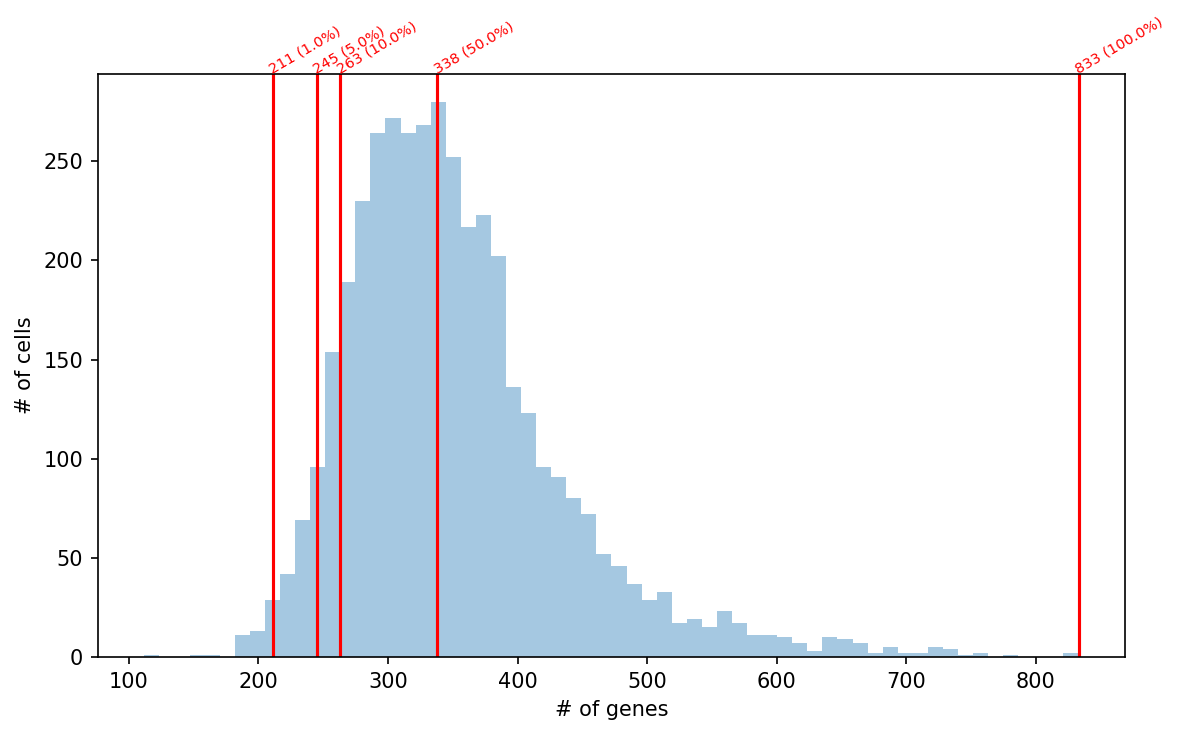

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=p_df.values[i], ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({p_df.index.values[i]*100}%)',
            color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

In [36]:
!pyscenic aucell \
    {f_loom_path_unfilt} \
    PN1_reg.csv \
    --output {f_pyscenic_output} \
    --num_workers 7


2022-06-30 11:51:08,494 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2022-06-30 11:51:08,669 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2022-06-30 11:51:09,427 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2022-06-30 11:51:12,252 - pyscenic.cli.pyscenic - INFO - Writing results to file.



### Visualization of SCENIC's AUC matrix

First, load the relevant data from the loom we just created


In [37]:

# collect SCENIC AUCell output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [38]:


# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "PN1_scenic_umap.txt", sep='\t')
# tSNE
tsne = TSNE( n_jobs=20 )
dr_tsne = tsne.fit_transform( auc_mtx )
pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "PN1_scenic_tsne.txt", sep='\t')


### Integrate the output

Here, we combine the results from SCENIC and the Scanpy analysis into a SCope-compatible loom file


In [3]:
adata = sc.read_h5ad( f_anndata_path )



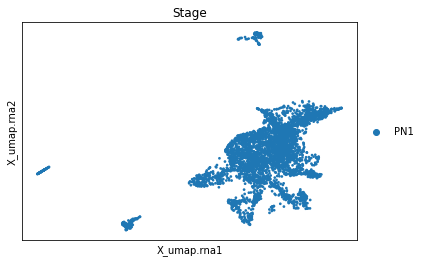

In [4]:
Stage = {0 : "PN1"}
adata.obs['Stage'] = (
    adata.obs["orig.ident"]
    .map(Stage)
.astype('category')
)
sc.pl.embedding(adata, "X_umap.rna", color="Stage")

In [5]:
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( 'PN1_scenic_umap.txt', sep='\t', header=0, index_col=0 )
dr_tsne = pd.read_csv( 'PN1_scenic_tsne.txt', sep='\t', header=0, index_col=0 )
###


Fix regulon objects to display properly in SCope:


In [6]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )

/home/irepan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.



Concatenate embeddings (tSNE, UMAP, etc.)


In [7]:
tsneDF = pd.DataFrame(adata.obsm['X_tsne'], columns=['_X', '_Y'])

Embeddings_X = pd.DataFrame( index=lf.ca.CellID )
Embeddings_X = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[0] , 
        pd.DataFrame(adata.obsm["X_umap.rna"],index=adata.obs.index)[0] , 
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[0] ,
        dr_tsne['X'] ,
        dr_umap['X']
    ], sort=False, axis=1, join='outer' )
Embeddings_X.columns = ['1','2','3','4','5']

Embeddings_Y = pd.DataFrame( index=lf.ca.CellID )
Embeddings_Y = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[1] ,
        pd.DataFrame(adata.obsm["X_umap.rna"],index=adata.obs.index)[1] , 
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[1] ,
        dr_tsne['Y'] ,
        dr_umap['Y']
    ], sort=False, axis=1, join='outer' )
Embeddings_Y.columns = ['1','2','3','4','5']



Metadata:


In [8]:
adata

AnnData object with n_obs × n_vars = 4058 × 2330
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Cell_Type', 'Phase', 'doublets', 'res.0.5', 'n_counts', 'louvain', 'Stage'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'res.0.5_colors', 'umap', 'Stage_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_umap.rna'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [9]:
### metadata
metaJson = {}

metaJson['embeddings'] = [
    {
        "id": -1,
        "name": f"Scanpy t-SNE (highly variable genes)"
    },
    {
        "id": 1,
        "name": f"Scanpy UMAP  (highly variable genes)"
    },
    {
        "id": 2,
        "name": f"Harmony UMAP  (PN1)"
    },
    {
        "id": 3,
        "name": "Scanpy PC1/PC2"
    },
    {
        "id": 4,
        "name": "SCENIC AUC t-SNE"
    },
    {
        "id": 5,
        "name": "SCENIC AUC UMAP"
    },
]

#metaJson["clusterings"] = [{
#            "id": 0,
#            "group": "Seurat",
#            "name": "Seurat res 0.5 harmony",
#            "clusters": [],
#        }]

metaJson["clusterings"] = [
        {
            "id": 0,
            "group": "Scanpy",
            "name": "Scanpy louvain default resolution",
            "clusters": [],
        },
        {
            "id": 1,
            "group": "Seurat",
            "name": "Seurat res 0.5 harmony",
            "clusters": [],
        }
]


metaJson["metrics"] = [
        {
            "name": "nCount_RNA"
        }, {
            "name": "nFeature_RNA"
        }, {
            "name": "percent.mt"
        }
]

metaJson["annotations"] = [
    {
        "name": "Seurat_clusters_res0_5",
        "values": list(set( adata.obs["res.0.5"].astype(np.str) ))
    },
    {
        "name": "Phase",
        "values": list(set( adata.obs["Phase"].astype(np.str) ))
    },
    {
        "name": "Cell_Type",
        "values": list(set( adata.obs["Cell_Type"].astype(np.str) ))
    },
    {
        "name": "Louvain_clusters_Scanpy",
        "values": list(set( adata.obs['louvain'].astype(np.str) ))
    }    
]

# SCENIC regulon thresholds:
metaJson["regulonThresholds"] = rt

#for i in range(max(set([int(x) for x in adata.obs["res.0.5"]])) + 1):
#    clustDict = {}
#    clustDict['id'] = i
#    clustDict['description'] = f'Unannotated Cluster {i + 1}'
#    metaJson['clusterings'][0]['clusters'].append(clustDict)
#    
#clusterings = pd.DataFrame()
#clusterings["0"] = adata.obs['louvain'].values.astype(np.int64)

for i in range(max(set([int(x) for x in adata.obs['louvain']])) + 1):
    clustDict = {}
    clustDict['id'] = i
    clustDict['description'] = f'Unannotated Cluster {i + 1}'
    metaJson['clusterings'][0]['clusters'].append(clustDict)
    
clusterings = pd.DataFrame()
clusterings["0"] = adata.obs['louvain'].values.astype(np.int64)



/home/irepan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/irepan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/irepan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:75: DeprecationWarning: `np.str` is a deprecated ali


Assemble loom file row and column attributes


In [10]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

In [11]:
col_attrs = {
    "CellID": np.array(adata.obs.index),
    "nCount_RNA": np.array(adata.obs['nCount_RNA'].values),
    "nFeature_RNA": np.array(adata.obs['nFeature_RNA'].values),
    "Louvain_clusters_Scanpy": np.array( adata.obs['louvain'].values ),
    "Seurat_clusters_res0_5": np.array( adata.obs['res.0.5'].values ),
    #"Genotype": np.array(adata.obs['Genotype'].values),
    "Stage": np.array(adata.obs['Stage'].values),
    #"Sample": np.array(adata.obs['Sample'].values),
    "Percent_mito": np.array(adata.obs['percent.mt'].values),
    "Embedding": dfToNamedMatrix(tsneDF),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    "RegulonsAUC": dfToNamedMatrix(auc_mtx),
    "Clusterings": dfToNamedMatrix(clusterings),
    "ClusterID": np.array(adata.obs['louvain'].values)
}

row_attrs = {
    "Gene": lf.ra.Gene,
    "Regulons": regulons,
}

attrs = {
    "title": "sampleTitle",
    "MetaData": json.dumps(metaJson),
    "Genome": 'mm10',
    "SCopeTreeL1": "",
    "SCopeTreeL2": "",
    "SCopeTreeL3": ""
}

# compress the metadata field:
attrs['MetaData'] = base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii')




Create a new loom file, copying the expression matrix from the open loom connection:


In [12]:
lp.create(
    filename = f_final_loom ,
    layers=lf[:,:],
    row_attrs=row_attrs, 
    col_attrs=col_attrs, 
    file_attrs=attrs
)
lf.close() # close original pyscenic loom file



This loom file can now be imported into SCope.


In [13]:
#regulons
auc_mtx.columns

Index(['Atf3_(+)', 'Barx1_(+)', 'Bcl3_(+)', 'Brf1_(+)', 'Cebpb_(+)',
       'Cebpd_(+)', 'Cux1_(+)', 'Ddit3_(+)', 'Dlx5_(+)', 'Dtl_(+)', 'En1_(+)',
       'Ezh2_(+)', 'Fosb_(+)', 'Fosl1_(+)', 'Foxc1_(+)', 'Foxd1_(+)',
       'Foxd3_(+)', 'Foxp2_(+)', 'Gata6_(+)', 'Hmga2_(+)', 'Hoxa11_(+)',
       'Hoxa3_(+)', 'Hoxa5_(+)', 'Hoxb4_(+)', 'Hoxd10_(+)', 'Hoxd11_(+)',
       'Hoxd13_(+)', 'Irf1_(+)', 'Irf8_(+)', 'Irx3_(+)', 'Jun_(+)', 'Junb_(+)',
       'Klf12_(+)', 'Klf4_(+)', 'Klf5_(+)', 'Klf8_(+)', 'Lhx8_(+)', 'Ltf_(+)',
       'Luzp2_(+)', 'Maf_(+)', 'Mafa_(+)', 'Mafb_(+)', 'Maff_(+)', 'Meis2_(+)',
       'Mkx_(+)', 'Msc_(+)', 'Msx1_(+)', 'Myc_(+)', 'Myf5_(+)', 'Myod1_(+)',
       'Myog_(+)', 'Nfkb1_(+)', 'Nr1d1_(+)', 'Pitx2_(+)', 'Pou3f1_(+)',
       'Ppard_(+)', 'Pparg_(+)', 'Prdm6_(+)', 'Runx2_(+)', 'Runx3_(+)',
       'Rxrg_(+)', 'Sap30_(+)', 'Six4_(+)', 'Sox10_(+)', 'Sox2_(+)',
       'Sox4_(+)', 'Sox5_(+)', 'Sox9_(+)', 'Sp7_(+)', 'Spi1_(+)', 'Stat2_(+)',
       'Tbx3_(+)', 'Tcf7l2_

In [16]:
# scenic output
lf = lp.connect( f_final_loom, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [17]:
# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

In [18]:
lf.col_attrs.items

<bound method AttributeManager.items of <loompy.attribute_manager.AttributeManager object at 0x7f913ba5c7d0>>

In [19]:
# cell annotations from the loom column attributes:
cellAnnot = pd.concat(
    [
        pd.DataFrame( lf.ca.CellID, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.Stage, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.Seurat_clusters_res0_5, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.Louvain_clusters_Scanpy, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.Percent_mito, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nFeature_RNA, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nCount_RNA, index=lf.ca.CellID ),
    ],
    axis=1
)
cellAnnot.columns = [
 'CellID',
 'Stage',
 'Seurat_clusters_res0_5',
 'Louvain_clusters_Scanpy',
 'Percent_mito',
 'nFeature_RNA',
 'nCount_RNA']


In [20]:
# capture embeddings:
dr = [
    pd.DataFrame( lf.ca.Embedding, index=lf.ca.CellID )
]
dr_names = [
    meta['embeddings'][0]['name'].replace(" ","_")
]

# add other embeddings
drx = pd.DataFrame( lf.ca.Embeddings_X, index=lf.ca.CellID )
dry = pd.DataFrame( lf.ca.Embeddings_Y, index=lf.ca.CellID )

for i in range( len(drx.columns) ):
    dr.append( pd.concat( [ drx.iloc[:,i], dry.iloc[:,i] ], sort=False, axis=1, join='outer' ))
    dr_names.append( meta['embeddings'][i+1]['name'].replace(" ","_").replace('/','-') )

# rename columns:
for i,x in enumerate( dr ):
    x.columns = ['X','Y']

In [21]:
lf.close()

In [22]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,Cell_Type,Phase,doublets,res.0.5,n_counts,louvain,Stage
PN1_AAACCCAGTGAACGGT-1,0,5874.0,2260,0.970378,PaS/EndostealFibroblasts,G1,Singlet,c_2,5874.0,1,PN1
PN1_AAACCCATCATGCCGG-1,0,8852.0,2713,2.971080,PaS/EndostealFibroblasts,G1,Singlet,c_1,8852.0,0,PN1
PN1_AAACCCATCTTACTGT-1,0,7739.0,2687,1.434294,CAR,G1,Singlet,c_2,7739.0,1,PN1
PN1_AAACGAAAGAGAGGTA-1,0,10490.0,2841,1.954242,PaS/EndostealFibroblasts,G1,Singlet,c_1,10490.0,0,PN1
PN1_AAACGAACAAGAGGTC-1,0,19360.0,4262,2.391529,PaS/EndostealFibroblasts,G1,Singlet,c_1,19360.0,0,PN1
...,...,...,...,...,...,...,...,...,...,...,...
PN1_TTTGTTGAGAGACAAG-1,0,3922.0,1751,2.498725,OCP,G1,Singlet,c_4,3922.0,5,PN1
PN1_TTTGTTGAGTAAGACT-1,0,10262.0,2823,1.783278,PaS/EndostealFibroblasts,G1,Singlet,c_1,10262.0,1,PN1
PN1_TTTGTTGAGTCCCAAT-1,0,16551.0,4434,1.154009,PaS/EndostealFibroblasts,S,Singlet,c_1,16551.0,3,PN1
PN1_TTTGTTGCAAACAGGC-1,0,11883.0,2994,1.144492,PaS/EndostealFibroblasts,G1,Singlet,c_1,11883.0,0,PN1


In [23]:
# helper functions (not yet integrated into pySCENIC):

from pyscenic.utils import load_motifs
import operator as op
from IPython.display import HTML, display

BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
    df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
    MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 200)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [24]:
df_motifs = load_motifs('PN1_reg.csv')

In [25]:
df_motifs

Enrichment            \
                                                AUC       NES   
TF     MotifID                                                  
Barx1  cisbp__M5298                        0.085265  3.211239   
       taipale__BARHL2_full_NNTAATTGNN     0.084923  3.186686   
Bcl3   jaspar__MA0101.1                    0.096044  3.191643   
       cisbp__M4499                        0.095608  3.167118   
       transfac_pro__M03545                0.105740  3.736941   
...                                             ...       ...   
Stat2  hocomoco__IRF1_MOUSE.H11MO.0.A      0.096023  3.609208   
       transfac_pro__M04788                0.093034  3.404900   
       factorbook__STAT2                   0.088243  3.077344   
Tcf7l2 transfac_pro__M01092                0.091674  3.082025   
Tfdp2  dbcorrdb__E2F4__ENCSR000DYY_1__m1   0.123428  5.947282   

                                                                \
                                         MotifSimilarityQvalue   
TF     MotifID                                                   
Barx1  cisbp__M5298                                   0.000032   
       taipale__BARHL2_full_NNTAATTGNN                0.000035   
Bcl3   jaspar__MA0101.1                               0.000012   
       cisbp__M4499                                   0.000000   
       transfac_pro__M03545                           0.000204   
...                                                        ...   
Stat2  hocomoco__IRF1_MOUSE.H11MO.0.A                 0.000014   
       transfac_pro__M04788                           0.000407   
       factorbook__STAT2                              0.000000   
Tcf7l2 transfac_pro__M01092                           0.000000   
Tfdp2  dbcorrdb__E2F4__ENCSR000DYY_1__m1              0.000050   

                                                              \
                                         OrthologousIdentity   
TF     MotifID                                                 
Barx1  cisbp__M5298                                 1.000000   
       taipale__BARHL2_full_NNTAATTGNN              1.000000   
Bcl3   jaspar__MA0101.1                             0.808370   
       cisbp__M4499                                 0.819196   
       transfac_pro__M03545                         0.819196   
...                                                      ...   
Stat2  hocomoco__IRF1_MOUSE.H11MO.0.A               0.687427   
       transfac_pro__M04788                         0.687427   
       factorbook__STAT2                            0.687427   
Tcf7l2 transfac_pro__M01092                         0.369565   
Tfdp2  dbcorrdb__E2F4__ENCSR000DYY_1__m1            0.822870   

                                                                                             \
                                                                                 Annotation   
TF     MotifID                                                                                
Barx1  cisbp__M5298                       gene is annotated for similar motif cisbp__M09...   
       taipale__BARHL2_full_NNTAATTGNN    gene is annotated for similar motif cisbp__M09...   
Bcl3   jaspar__MA0101.1                   motif similar to factorbook__NFKB1 ('NFKB1'; q...   
       cisbp__M4499                       gene is orthologous to ENSG00000069399 in H. s...   
       transfac_pro__M03545               gene is orthologous to ENSG00000069399 in H. s...   
...                                                                                     ...   
Stat2  hocomoco__IRF1_MOUSE.H11MO.0.A     motif similar to hocomoco__STAT2_HUMAN.H11MO.0...   
       transfac_pro__M04788               motif similar to hocomoco__STAT2_HUMAN.H11MO.0...   
       factorbook__STAT2                  motif is annotated for orthologous gene ENSG00...   
Tcf7l2 transfac_pro__M01092               gene is orthologous to FBgn0085432 in D. melan...   
Tfdp2  dbcorrdb__E2F4__ENCSR000DYY_1__m1  motif similar to transfac_pro__

In [26]:
selected_motifs = ['Foxa3','Hes1','Sox9']
df_motifs_sel = df_motifs.iloc[ [ True if x in selected_motifs else False for x in df_motifs.index.get_level_values('TF') ] ,:]

In [27]:
#display_logos(df_motifs.head())
display_logos( df_motifs_sel.sort_values([('Enrichment','NES')], ascending=False).head(9))

In [28]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
import matplotlib as mpl
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

In [29]:
cellAnnot

,CellID,Stage,Seurat_clusters_res0_5,Louvain_clusters_Scanpy,Percent_mito,nFeature_RNA,nCount_RNA
PN1_AAACCCAGTGAACGGT-1,PN1_AAACCCAGTGAACGGT-1,PN1,c_2,1,0.970378,2260,5874.0
PN1_AAACCCATCATGCCGG-1,PN1_AAACCCATCATGCCGG-1,PN1,c_1,0,2.971080,2713,8852.0
PN1_AAACCCATCTTACTGT-1,PN1_AAACCCATCTTACTGT-1,PN1,c_2,1,1.434294,2687,7739.0
PN1_AAACGAAAGAGAGGTA-1,PN1_AAACGAAAGAGAGGTA-1,PN1,c_1,0,1.954242,2841,10490.0
PN1_AAACGAACAAGAGGTC-1,PN1_AAACGAACAAGAGGTC-1,PN1,c_1,0,2.391529,4262,19360.0
...,...,...,...,...,...,...,...
PN1_TTTGTTGAGAGACAAG-1,PN1_TTTGTTGAGAGACAAG-1,PN1,c_4,5,2.498725,1751,3922.0
PN1_TTTGTTGAGTAAGACT-1,PN1_TTTGTTGAGTAAGACT-1,PN1,c_1,1,1.783278,2823,10262.0
PN1_TTTGTTGAGTCCCAAT-1,PN1_TTTGTTGAGTCCCAAT-1,PN1,c_1,3,1.154009,4434,16551.0
PN1_TTTGTTGCAAACAGGC-1,PN1_TTTGTTGCAAACAGGC-1,PN1,c_1,0,1.144492,2994,11883.0


## Regulon Specificity Score

### RSS by cluster

In [30]:
rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot['Seurat_clusters_res0_5'] )
rss_cellType

,Atf3_(+),Barx1_(+),Bcl3_(+),Brf1_(+),Cebpb_(+),Cebpd_(+),Cux1_(+),Ddit3_(+),Dlx5_(+),Dtl_(+),...,Sp7_(+),Spi1_(+),Stat2_(+),Tbx3_(+),Tcf7l2_(+),Tfdp2_(+),Tgif1_(+),Thap1_(+),Twist2_(+),Zfp959_(+)
c_2,0.218293,0.221451,0.265242,0.290951,0.261481,0.320541,0.253934,0.241584,0.217595,0.242068,...,0.228451,0.282003,0.298202,0.312124,0.353491,0.267546,0.218596,0.251322,0.210291,0.219907
c_1,0.379998,0.392256,0.385313,0.365194,0.406734,0.393809,0.373478,0.351893,0.270093,0.307334,...,0.301226,0.383361,0.402468,0.335752,0.371050,0.334110,0.288307,0.329719,0.347142,0.293248
c_4,0.274020,0.313932,0.231091,0.214669,0.258207,0.195257,0.353513,0.205514,0.184628,0.198231,...,0.205926,0.244960,0.214059,0.195706,0.199694,0.207997,0.194810,0.205899,0.195503,0.215931
c_8,0.192326,0.179199,0.198277,0.189668,0.189519,0.184878,0.243804,0.200934,0.172089,0.212685,...,0.179271,0.200421,0.189539,0.186307,0.192273,0.243394,0.197224,0.180596,0.174315,0.189495
c_10,0.174179,0.177843,0.177150,0.183812,0.180721,0.178734,0.235031,0.174051,0.178283,0.184098,...,0.186649,0.183890,0.186625,0.172921,0.181347,0.193724,0.170092,0.175227,0.170341,0.174056
c_3,0.268471,0.329415,0.235161,0.262484,0.264208,0.250628,0.251626,0.265227,0.268421,0.235528,...,0.272545,0.279589,0.237960,0.234582,0.248957,0.247264,0.264352,0.224923,0.214022,0.232672
c_5,0.200141,0.212885,0.231554,0.200110,0.221826,0.202519,0.208520,0.263107,0.185521,0.362567,...,0.190206,0.226259,0.231680,0.188065,0.214574,0.388979,0.202501,0.244093,0.206445,0.201005
c_0,0.329128,0.300312,0.343484,0.367107,0.373108,0.425429,0.289087,0.306774,0.289656,0.290313,...,0.305056,0.336678,0.412800,0.289720,0.394399,0.320830,0.277570,0.290674,0.379579,0.267349
c_9,0.171788,0.196750,0.222648,0.194462,0.200373,0.185006,0.192523,0.180501,0.429450,0.181862,...,0.434391,0.206391,0.183022,0.175486,0.192501,0.188880,0.175943,0.177512,0.175440,0.179109
c_7,0.204236,0.195200,0.238972,0.260572,0.227883,0.240474,0.220388,0.226001,0.204352,0.211988,...,0.201080,0.222114,0.234760,0.207983,0.236689,0.223877,0.197086,0.220075,0.214969,0.218744


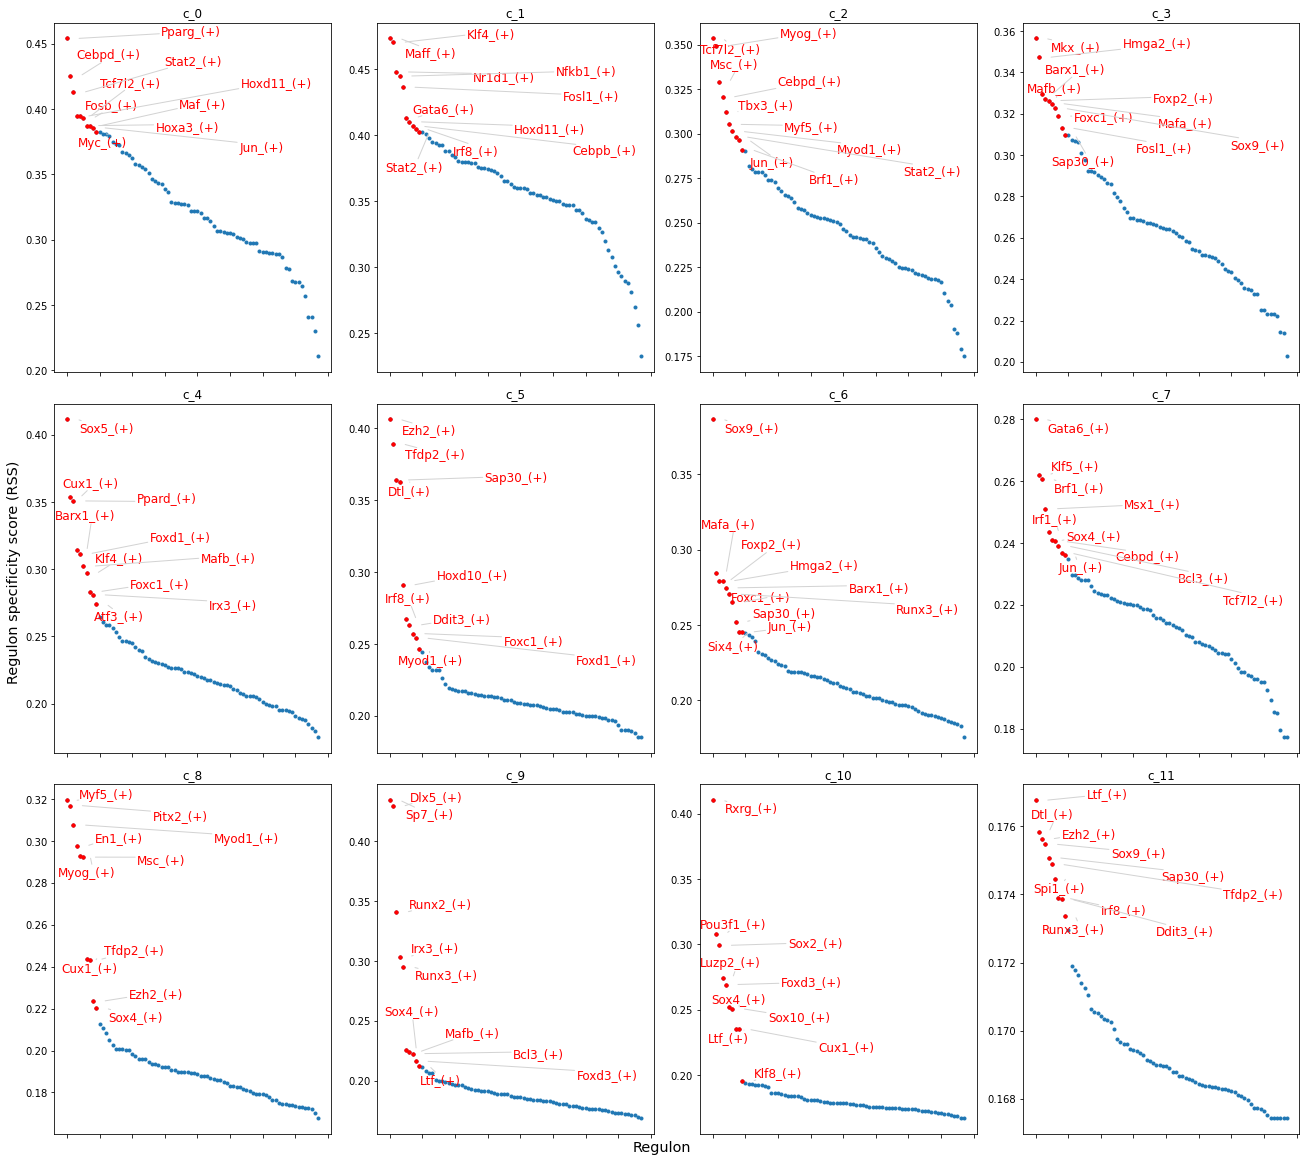

In [31]:
#cats = sorted(list(set(cellAnnot['Seurat_clusters_res0_5'])))
cats = ['c_0', 'c_1', 'c_2', 'c_3', 'c_4',
        'c_5', 'c_6', 'c_7', 'c_8', 'c_9',
        'c_10', 'c_11']

fig = plt.figure(figsize=(18, 16))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(3,4,num)
    plot_rss(rss_cellType, c, top_n=10, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("PN1_clusters-RSS-top10.pdf", dpi=600, bbox_inches = "tight")
plt.show()

In [66]:
rss_cellType.to_csv("rss_cellType_PN1.csv" )

In [67]:
regulons

{'Atf3_(+)': ['Zdbf2',
  'Btg2',
  'Atf3',
  'Arl5b',
  'Tnfaip6',
  'Nr4a2',
  'Gdf5',
  'Top1',
  'Tsc22d2',
  'Nfkb1',
  'Dnajb4',
  'Gem',
  'Nr4a3',
  'Klf4',
  'Jun',
  'Errfi1',
  'Il6',
  'Tra2a',
  'Creb5',
  'Gprc5a',
  'Fosb',
  'Ier2',
  'Junb',
  'Egr2',
  'Ddit3',
  'Rhob',
  'Ifrd1',
  'Klf6',
  'Tubb2a',
  'Hmgcs1',
  'Stmn4',
  'Trib1',
  'Maff',
  'Nr4a1',
  'Nfkbiz',
  'Rcan1',
  'Has1',
  'Dusp1',
  'Zfp36l2',
  'Rbbp8',
  'Egr1',
  'Cystm1',
  'Frat2',
  'Sat1'],
 'Barx1_(+)': ['Crispld1',
  'Gpr1',
  'Prg4',
  'Pcp4l1',
  'Atf3',
  'Proser2',
  'Ass1',
  'Ptgs1',
  'Nr4a2',
  'Hoxd8',
  'Zfp385b',
  'Gm13889',
  'Mpped2',
  'Grem1',
  'Bmp2',
  'Plcb1',
  'Btbd3',
  'Ism1',
  'Gdf5',
  'Top1',
  'Matn4',
  'Sulf2',
  'Pmepa1',
  'Jade1',
  'Tsc22d2',
  'Efna1',
  'S100a4',
  'Tspan2',
  'Col25a1',
  'Npnt',
  'Fam214b',
  'Tpm2',
  'Nr4a3',
  'Klf4',
  'Col27a1',
  'Slc6a9',
  'Azin2',
  'Rnf19b',
  'Col16a1',
  'Sfn',
  'Dhrs3',
  'Fbxo2',
  'Errfi1',
  'Sema3d',

In [68]:
auc_mtx

,Atf3_(+),Barx1_(+),Bcl3_(+),Brf1_(+),Cebpb_(+),Cebpd_(+),Cux1_(+),Ddit3_(+),Dlx5_(+),Dtl_(+),...,Sp7_(+),Spi1_(+),Stat2_(+),Tbx3_(+),Tcf7l2_(+),Tfdp2_(+),Tgif1_(+),Thap1_(+),Twist2_(+),Zfp959_(+)
PN1_AAACCCAGTGAACGGT-1,0.004506,0.020411,0.019231,0.033251,0.023388,0.048301,0.019149,0.009442,0.036877,0.011494,...,0.031544,0.022649,0.029296,0.000000,0.037226,0.028205,0.000000,0.000000,0.000000,0.000000
PN1_AAACCCATCATGCCGG-1,0.012343,0.013248,0.041777,0.014368,0.023361,0.018794,0.013808,0.036946,0.000000,0.029693,...,0.022335,0.020768,0.020602,0.000000,0.021272,0.017288,0.000000,0.000000,0.000000,0.000000
PN1_AAACCCATCTTACTGT-1,0.000000,0.010459,0.036737,0.029351,0.015805,0.031979,0.018996,0.014368,0.056034,0.000000,...,0.006661,0.008895,0.006173,0.000000,0.060905,0.015555,0.000000,0.000000,0.065047,0.050493
PN1_AAACGAAAGAGAGGTA-1,0.020768,0.022312,0.022812,0.034483,0.031050,0.013502,0.016097,0.012726,0.066092,0.000000,...,0.021552,0.015086,0.011726,0.181034,0.023791,0.013118,0.011494,0.017241,0.000000,0.133005
PN1_AAACGAACAAGAGGTC-1,0.061520,0.028715,0.014456,0.020731,0.028150,0.011853,0.016326,0.086207,0.000000,0.000000,...,0.000000,0.028644,0.014538,0.035714,0.025190,0.023894,0.000000,0.077586,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PN1_TTTGTTGAGAGACAAG-1,0.030956,0.059140,0.000000,0.042898,0.019929,0.002884,0.034178,0.023810,0.025862,0.000000,...,0.010580,0.012265,0.009023,0.000000,0.005822,0.011853,0.000000,0.000000,0.000000,0.102217
PN1_TTTGTTGAGTAAGACT-1,0.006857,0.010712,0.008223,0.031609,0.019822,0.036194,0.015716,0.013957,0.009579,0.008621,...,0.010384,0.015792,0.021296,0.000000,0.026646,0.010214,0.000000,0.000000,0.000000,0.086207
PN1_TTTGTTGAGTCCCAAT-1,0.009404,0.013692,0.027719,0.024631,0.013011,0.006149,0.029448,0.016831,0.000000,0.136973,...,0.000000,0.007641,0.030465,0.115764,0.015450,0.030594,0.000000,0.031897,0.000000,0.000000
PN1_TTTGTTGCAAACAGGC-1,0.023903,0.016417,0.037268,0.002874,0.033605,0.030775,0.011749,0.068144,0.000000,0.000000,...,0.014107,0.034013,0.041679,0.094828,0.030956,0.012509,0.000000,0.093966,0.000000,0.000000



## Select the top 5 regulons from each cell type

In [69]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))


### Generate a Z-score for each regulon to enable comparison between regulons


In [70]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

### Generate a heatmap

In [71]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [72]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot['Seurat_clusters_res0_5'] ]

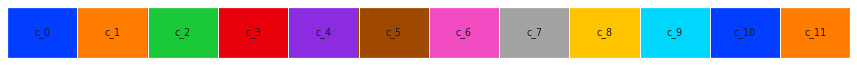

In [73]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)
#plt.savefig("PN1_clusters-heatmap-legend-top5.pdf", dpi=600, bbox_inches = "tight")

/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, -52.68237500000015, '')

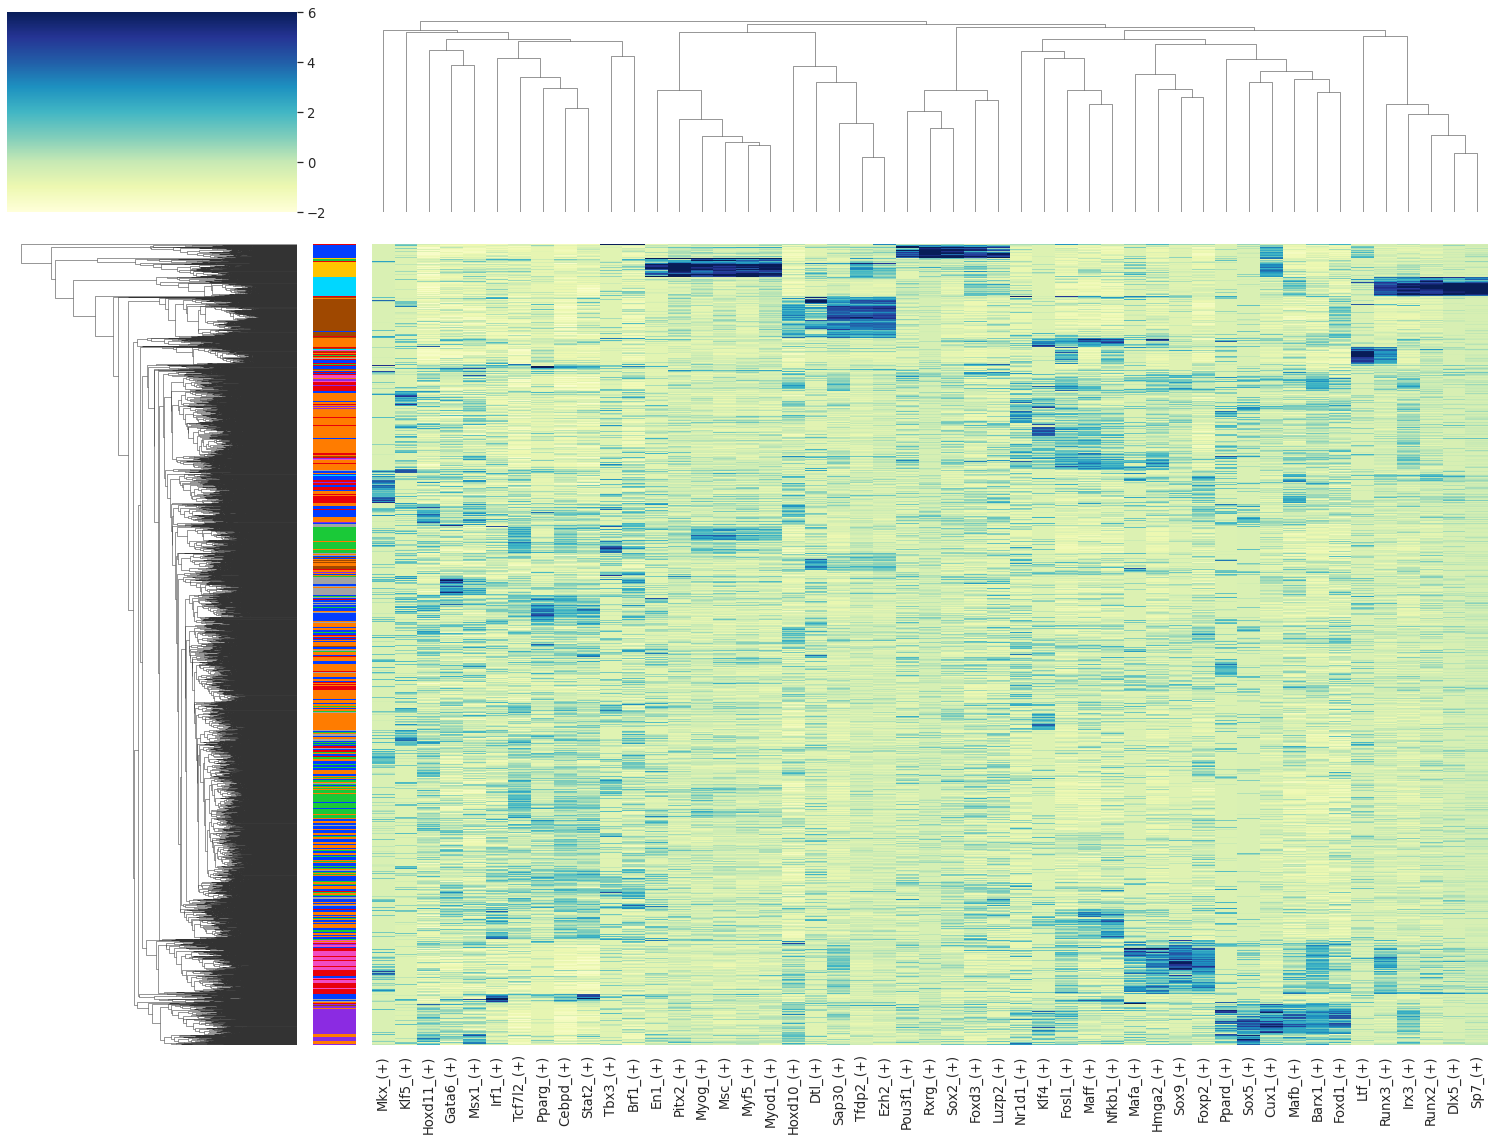

In [74]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')    
g.ax_heatmap.set_xlabel('')    



## Further exploration of modules directly from the network inference output 


In [75]:
adjacencies = pd.read_csv("PN1_adj.csv", index_col=False, sep=',')

#### Create the modules:

In [76]:
from pyscenic.utils import modules_from_adjacencies
modules = list(modules_from_adjacencies(adjacencies, exprMat))


2022-06-30 11:52:31,621 - pyscenic.utils - INFO - Calculating Pearson correlations.

2022-06-30 11:52:31,661 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2022-06-30 11:52:33,382 - pyscenic.utils - INFO - Creating modules.


In [77]:
tf = 'Sox10'
tf_mods = [ x for x in modules if x.transcription_factor==tf ]

for i,mod in enumerate( tf_mods ):
    print( f'{tf} module {str(i)}: {len(mod.genes)} genes' )
print( f'{tf} regulon: {len(regulons[tf+"_(+)"])} genes' )

Sox10 module 0: 345 genes
Sox10 module 1: 264 genes
Sox10 module 2: 51 genes
Sox10 module 3: 195 genes
Sox10 module 4: 255 genes
Sox10 module 5: 474 genes
Sox10 regulon: 226 genes


In [78]:
regulons

{'Atf3_(+)': ['Zdbf2',
  'Btg2',
  'Atf3',
  'Arl5b',
  'Tnfaip6',
  'Nr4a2',
  'Gdf5',
  'Top1',
  'Tsc22d2',
  'Nfkb1',
  'Dnajb4',
  'Gem',
  'Nr4a3',
  'Klf4',
  'Jun',
  'Errfi1',
  'Il6',
  'Tra2a',
  'Creb5',
  'Gprc5a',
  'Fosb',
  'Ier2',
  'Junb',
  'Egr2',
  'Ddit3',
  'Rhob',
  'Ifrd1',
  'Klf6',
  'Tubb2a',
  'Hmgcs1',
  'Stmn4',
  'Trib1',
  'Maff',
  'Nr4a1',
  'Nfkbiz',
  'Rcan1',
  'Has1',
  'Dusp1',
  'Zfp36l2',
  'Rbbp8',
  'Egr1',
  'Cystm1',
  'Frat2',
  'Sat1'],
 'Barx1_(+)': ['Crispld1',
  'Gpr1',
  'Prg4',
  'Pcp4l1',
  'Atf3',
  'Proser2',
  'Ass1',
  'Ptgs1',
  'Nr4a2',
  'Hoxd8',
  'Zfp385b',
  'Gm13889',
  'Mpped2',
  'Grem1',
  'Bmp2',
  'Plcb1',
  'Btbd3',
  'Ism1',
  'Gdf5',
  'Top1',
  'Matn4',
  'Sulf2',
  'Pmepa1',
  'Jade1',
  'Tsc22d2',
  'Efna1',
  'S100a4',
  'Tspan2',
  'Col25a1',
  'Npnt',
  'Fam214b',
  'Tpm2',
  'Nr4a3',
  'Klf4',
  'Col27a1',
  'Slc6a9',
  'Azin2',
  'Rnf19b',
  'Col16a1',
  'Sfn',
  'Dhrs3',
  'Fbxo2',
  'Errfi1',
  'Sema3d',

In [79]:
tf_mods

[Regulon(name='Regulon for Sox10', gene2weight=frozendict.frozendict({'Plp1': 68.84183075159113, 'Egfl8': 59.71268331176655, 'Foxd3': 56.96409688771085, 'Mpz': 53.46393659246777, 'Cnp': 52.35995064251354, 'Kcna1': 46.73050843761165, 'Mal': 43.141092262402296, 'Gask1b': 43.02648766589454, 'Metrn': 42.322308659591975, 'Gas2l3': 41.67678583878534, 'Ednrb': 41.08797507289295, 'Cryab': 40.72342291883807, 'Gal3st1': 39.24441500417542, 'Cdh19': 38.82183065213475, 'Vgll3': 36.43074746101371, 'Gatm': 34.586127661286646, 'Plekhb1': 33.88314477160632, 'Slc35f1': 33.14948376307599, 'Ppp1r14c': 33.01524094808008, 'Art3': 32.925206831316046, 'Gpm6b': 32.86698437987756, 'Apoe': 32.58371853441558, 'Sostdc1': 32.54776909261602, 'Mcam': 32.193702491048995, 'Cadm4': 32.09568229944519, 'Erbb3': 31.56996464934569, 'Aatk': 31.05869027051929, 'Alcam': 30.908735872768457, 'Bcas1': 30.75750695653981, 'Fign': 30.56368300419677, 'Adam23': 30.41065424761256, 'Ptprz1': 30.313841696710835, 'Megf9': 30.2753689314773

In [80]:
#for i,mod in enumerate( tf_mods ):
#    with open( tf+'_module_'+str(i)+'.txt', 'w') as f:
#        for item in mod.genes:
#            f.write("%s\n" % item)
#            
#with open( tf+'_regulon.txt', 'w') as f:
#    for item in regulons[tf+'_(+)']:
#        f.write("%s\n" % item)